In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import warnings

warnings.filterwarnings('ignore')
import datetime

In [2]:
df_2020 = pd.read_csv('../data/richmond_apparatus_data.csv')
df_2019 = pd.read_csv('../data/richmond_apparatus_data_2019.csv')

In [3]:
df_tot = pd.concat([df_2019, df_2020]).reset_index()

In [4]:
df_tot = df_tot.dropna(subset=['apparatus_data.unit_status.arrived.timestamp'])

In [5]:
df_tot = df_tot[pd.to_datetime(df_tot['apparatus_data.unit_status.enroute.timestamp']) > pd.to_datetime(datetime.date(2019, 1, 9), utc=True)]
df_tot = df_tot[pd.to_datetime(df_tot['apparatus_data.unit_status.enroute.timestamp']) < pd.to_datetime(datetime.date(2021, 1, 1), utc=True)]


In [6]:
df_tot['description.event_opened'] = pd.to_datetime(df_tot['description.event_opened'])
df_tot['date'] = df_tot['description.event_opened'].progress_apply(lambda x: x.strftime('%Y-%m-%d'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77978/77978 [00:00<00:00, 229132.62it/s]


In [7]:
all_types = np.unique(df_tot['description.type'])

In [8]:
keywords = {'fire': ['FIRE'], 'crash':['ACCIDENT', 'CRASH','VEHICLE'], 'ems': ['EMS']}
types = {'fire': [], 'crash':[], 'ems': []}

In [9]:
for keyword in keywords.keys():
    for word in keywords[keyword]:
        for inc_type in all_types:
            if word in inc_type:
                types[keyword].append(inc_type)
    

In [12]:
def calculate_incident_type_weekly_avg(df, inc_type, type_dict):
    df = df_tot[df_tot['description.type'].isin(type_dict[inc_type])]
    daily_counts = df.groupby(['date']).size().reset_index(name='count')
    lower_bound = pd.to_datetime(datetime.date(2019, 1, 1), utc=True)
    upper_bound = pd.to_datetime(datetime.date(2020, 2, 6), utc=True)
    mask = (pd.to_datetime(daily_counts['date']).dt.date > lower_bound) & (pd.to_datetime(daily_counts['date']).dt.date < upper_bound)
    df_for_baseline = daily_counts.loc[mask]
    df_for_baseline['date'] = pd.to_datetime(df_for_baseline['date'])
    df_for_baseline['day_of_the_week'] = df_for_baseline['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
    df_for_baseline['month'] =  df_for_baseline['date'].dt.month
    baseline_per_day = df_for_baseline.groupby(['day_of_the_week']).median()['count'].to_frame().reset_index()
    baseline_per_day.columns = ['day_of_week', 'baseline_count']
    daily_counts['day_of_week'] = daily_counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
    df_compare = pd.merge(daily_counts, baseline_per_day, on=['day_of_week'], how='inner').reset_index()
    df_compare['change_from_baseline'] = (df_compare['count'])# - df_compare['baseline_count'])/df_compare['baseline_count']*100
    df_compare['avg_7_days'] = df_compare['change_from_baseline'].rolling(window=7, min_periods=1).mean(skipna=True)
    first_day_of_week = 'Monday'
    weekly_incident_change = df_compare[df_compare['day_of_week']==first_day_of_week]
    return weekly_incident_change
    

In [133]:
def calculate_incident_type_weekly_avg(df, inc_type, type_dict):
    df = df_tot[df_tot['description.type'].isin(type_dict[inc_type])]
    print(len(df))
    counts = df.groupby(['date']).size().reset_index(name='count')
    counts['year'] = pd.to_datetime(counts['date']).dt.year
    counts['day'] = pd.to_datetime(counts['date']).dt.day
    counts['month'] = pd.to_datetime(counts['date']).dt.month
    counts['day_of_week'] = counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
    baseline_month_day = counts[counts['year'] == 2019].groupby(['month','day_of_week']).median().reset_index()
    baseline_month_day = baseline_month_day.rename(columns={"count": "base_count"})
    merged_df = pd.merge(counts, baseline_month_day, how='inner', on=['month','day_of_week'])
    merged_df['change'] = (merged_df['count'] - merged_df['base_count'])/merged_df['base_count'] * 100
    merged_df = merged_df.sort_values('date')
    merged_df['avg_last_7_days'] = merged_df['change'].rolling(window=7, min_periods=1).mean(skipna=True)
    first_day_of_week = 'Monday'
    weekly_counts = merged_df[merged_df['day_of_week']==first_day_of_week]
    weekly_counts = weekly_counts.sort_values('date')
    return weekly_counts, merged_df
    

In [134]:
pear_is_wack = True

24527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 21257.80it/s]


9182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 20944.90it/s]


35813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 19965.26it/s]


(18307.0, 18659.7)

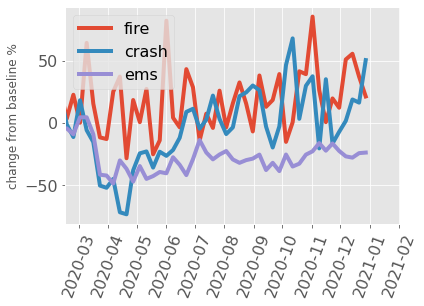

In [135]:
for inc_type in types.keys():
    weekly_incident_change, merged_df = calculate_incident_type_weekly_avg(df_tot, inc_type, types)
  #  plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'], alpha=.1)
    plt.plot(pd.to_datetime(weekly_incident_change['date']), weekly_incident_change['avg_last_7_days'], label=inc_type)
    plt.xticks(rotation=70)
    plt.legend()    
    plt.ylabel('change from baseline %')
plt.xlim(left=pd.to_datetime('2020-2-15'))
#plt.xlim(right=pd.to_datetime('2021-2-15'))



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 19890.85it/s]


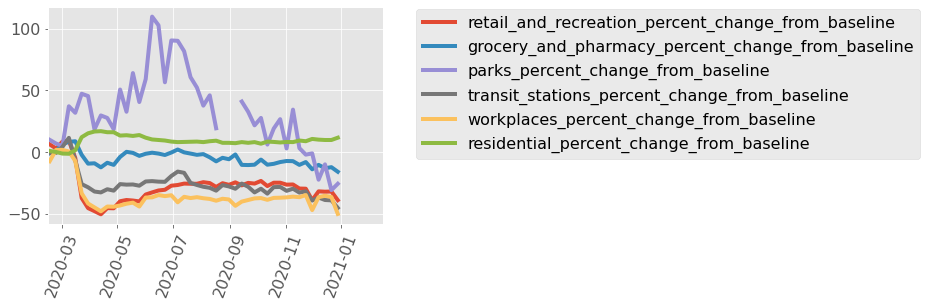

In [63]:
df_2020_google = pd.read_csv('../data/google_data/2020_US_Region_Mobility_Report.csv')
df_richmond = df_2020_google[df_2020_google['census_fips_code'] == int('51760')]

def get_mobility_data(df, data_type):
    mobility_df = df[['date', data_type]]
    mobility_df['avg_last_7_days'] = mobility_df[data_type].rolling(window=7, min_periods=1).mean(skipna=True)
    mobility_df['day_of_week'] = mobility_df['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
    first_day_of_week = 'Monday'
    weekly_mobility = mobility_df[mobility_df['day_of_week']==first_day_of_week]
    weekly_mobility['date'] = pd.to_datetime(weekly_mobility['date'])
    return weekly_mobility

for data_type in df_richmond.columns[9:]:
    weekly_mobility = get_mobility_data(df_richmond, data_type)
    plt.plot(weekly_mobility['date'], weekly_mobility['avg_last_7_days'], label=data_type)
    plt.legend(loc=(1.1,.3))
    plt.xlim(left=pd.to_datetime('2020-2-15'))
    plt.xlim(right=pd.to_datetime('2021-2-15'))
    plt.xticks(rotation=70)

In [116]:
merged_df

,date,count,year_x,day_x,month,day_of_week,base_count,year_y,day_y,change,avg_last_7_days
0,2019-01-08,14,2019,8,1,Tuesday,103.0,2019.0,18.5,-86.407767,-86.407767
8,2019-01-09,109,2019,9,1,Wednesday,115.5,2019.0,19.5,-5.627706,8.904780
17,2019-01-10,92,2019,10,1,Thursday,105.5,2019.0,20.5,-12.796209,4.727320
26,2019-01-11,129,2019,11,1,Friday,129.0,2019.0,18.0,0.000000,4.062288
34,2019-01-12,96,2019,12,1,Saturday,96.0,2019.0,19.0,0.000000,-11.295681
...,...,...,...,...,...,...,...,...,...,...,...
670,2020-12-27,104,2020,27,12,Sunday,99.0,2019.0,15.0,5.050505,3.607504
679,2020-12-28,106,2020,28,12,Monday,98.0,2019.0,16.0,8.163265,3.352770
689,2020-12-29,135,2020,29,12,Tuesday,104.0,2019.0,17.0,29.807692,5.219780
698,2020-12-30,115,2020,30,12,Wednesday,98.5,2019.0,14.5,16.751269,9.209572


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 13384.09it/s]


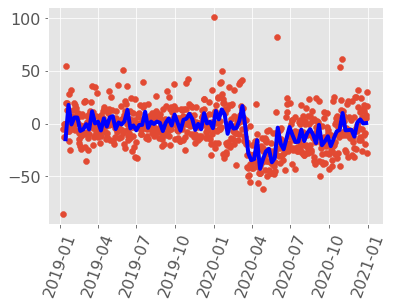

In [117]:
counts = df_tot.groupby(['date']).size().reset_index(name='count')
counts['year'] = pd.to_datetime(counts['date']).dt.year
counts['day'] = pd.to_datetime(counts['date']).dt.day
counts['month'] = pd.to_datetime(counts['date']).dt.month
counts['day_of_week'] = counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())
baseline_month_day = counts[counts['year'] == 2019].groupby(['month','day_of_week']).median().reset_index()
baseline_month_day = baseline_month_day.rename(columns={"count": "base_count"})
merged_df = pd.merge(counts, baseline_month_day, how='inner', on=['month','day_of_week'])
merged_df['change'] = (merged_df['count'] - merged_df['base_count'])/merged_df['base_count'] * 100
merged_df = merged_df.sort_values('date')

merged_df['avg_last_7_days'] = merged_df['change'].rolling(window=7, min_periods=1).mean(skipna=True)

first_day_of_week = 'Monday'
weekly_counts = merged_df[merged_df['day_of_week']==first_day_of_week]
weekly_counts = weekly_counts.sort_values('date')


plt.plot(pd.to_datetime(weekly_counts['date']), weekly_counts['avg_last_7_days'],color='blue')
plt.xticks(rotation=70);
plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'])

In [100]:
baseline_month_day = counts[counts['year'] == 2019].groupby(['month','day_of_week']).median().reset_index()
baseline_month_day = baseline_month_day.rename(columns={"count": "base_count"})
merged_df = pd.merge(counts, baseline_month_day, how='inner', on=['month','day_of_week'])
merged_df['change'] = (merged_df['count'] - merged_df['base_count'])/merged_df['base_count'] * 100

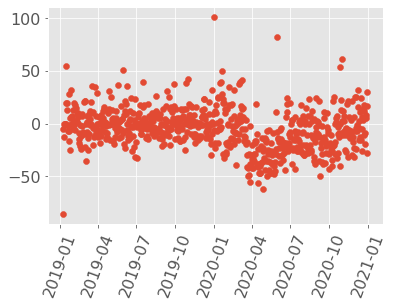

In [101]:
plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'])
merged_df = merged_df.sort_values('date')
plt.xticks(rotation=70);

In [102]:
merged_df['avg_last_7_days'] = merged_df['change'].rolling(window=7, min_periods=1).mean(skipna=True)
first_day_of_week = 'Monday'
weekly_counts = merged_df[merged_df['day_of_week']==first_day_of_week]
weekly_counts = weekly_counts.sort_values('date')

In [103]:
weekly_counts = weekly_counts.sort_values('date')

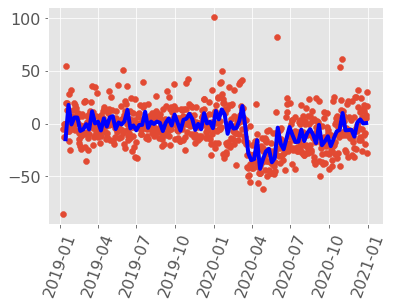

In [104]:
plt.plot(pd.to_datetime(weekly_counts['date']), weekly_counts['avg_last_7_days'],color='blue')
plt.xticks(rotation=70);
plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'])

#plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'])
#plt.ylim(-100,100)

In [105]:
counts = df_tot.groupby(['date']).size().reset_index(name='count')
counts['year'] = pd.to_datetime(counts['date']).dt.year
counts['day'] = pd.to_datetime(counts['date']).dt.day
counts['month'] = pd.to_datetime(counts['date']).dt.month
counts['day_of_week'] = counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 724/724 [00:00<00:00, 13519.11it/s]


In [106]:
baseline_month_day = counts[counts['year'] == 2019].groupby(['month','day_of_week']).median().reset_index()
baseline_month_day = baseline_month_day.rename(columns={"count": "base_count"})
merged_df = pd.merge(counts, baseline_month_day, how='inner', on=['month','day_of_week'])
merged_df['change'] = (merged_df['count'] - merged_df['base_count'])/merged_df['base_count'] * 100

In [111]:
merged_df['avg_last_7_days'] = merged_df['change'].rolling(window=7, min_periods=1).mean(skipna=True)
first_day_of_week = 'Monday'
weekly_counts = merged_df[merged_df['day_of_week']==first_day_of_week]
weekly_counts = weekly_counts.sort_values('date')

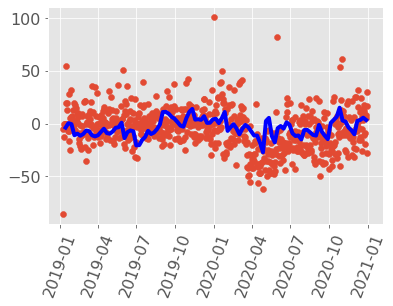

In [112]:
plt.plot(pd.to_datetime(weekly_counts['date']), weekly_counts['avg_last_7_days'],color='blue')
plt.xticks(rotation=70);
plt.scatter(pd.to_datetime(merged_df['date']), merged_df['change'])